Single fire truck dispatch evaluation

In [1]:
import os
import ast
import pickle
import pandas as pd
import numpy as np

from stable_baselines3 import SAC
from fire_dispatch_rl_env.environment import FireDispatchEnv
from fire_dispatch_rl_env.wrappers import ContinuousDispatchEnv

# === 📁 Load data ===
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
csv_path = r"D:\UCL2\final paper\data\real_with_dispatch_info.csv"
df = pd.read_csv(csv_path)
if isinstance(df.loc[0, 'graph_node'], str):
    df["graph_node"] = df["graph_node"].apply(ast.literal_eval)

with open("station_dists.pkl", "rb") as f:
    station_dists = pickle.load(f)
with open("station_mapping.pkl", "rb") as f:
    station_mapping = pickle.load(f)

station_xy = {}
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
xy_path = r"D:\UCL2\final paper\data\station_xy.pkl"
if os.path.exists(xy_path):
    with open(xy_path, "rb") as f:
        station_xy = pickle.load(f)

# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
counts_path = r"D:\UCL2\final paper\data\Station_engine_counts.csv"
df_counts = pd.read_csv(counts_path)
station_engine_counts = dict(zip(df_counts["Station name"], df_counts["station_engine_counts"]))

# === ⚙️ Environment configuration ===
config = {
    "max_engines": len(station_mapping),
    "cooldown_seconds": 180,
    "event_num": 50000,
    "max_steps": 50000,
    "map_width": 50000,
    "map_height": 50000,
    "obs_dim": 96,
    "obs_engine_count": 20,
    "station_dists": station_dists,
    "station_engine_counts": station_engine_counts,
    "station_xy": station_xy,
    "average_speed_kmph": 48,
    "max_dispatch_per_event": 2
}

# === 🌍 Initialize environment ===
base_env = FireDispatchEnv(config, event_df=df)
eval_env = ContinuousDispatchEnv(base_env)

# === 📦 Load model ===
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
model_path = r"models/fire_sac_debug_10w/final_model.zip"
assert os.path.exists(model_path), f"❌ Model not found: {model_path}"
model = SAC.load(model_path)

# === 🚨 Start evaluation ===
obs = eval_env.reset()
done = False
event_index = 0
dispatch_log = []

while not done and event_index < config["event_num"]:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = eval_env.step(action)

    wrapped_ids = info.get("wrapped_engine_ids", [])
    response_times = info.get("response_times", [])

    # Prevent the simulator from not yet recording the event
    if base_env.sim.finished_events:
        event_obj = base_env.sim.finished_events[-1]
        risk_level = getattr(event_obj, "risk_level", None)
        event_id = getattr(event_obj, "id", event_index)
    else:
        risk_level = None
        event_id = event_index

    for rank, (eid, rtime) in enumerate(zip(wrapped_ids, response_times)):
        dispatch_log.append({
            "event_index": event_index,
            "dispatch_rank": rank + 1,
            "engine_id": eid,
            "station": base_env.sim.station_mapping.get(eid, "Unknown"),
            "response_time": rtime,
            "event_id": event_id,
            "risk_level": risk_level
        })

    event_index += 1

# === 💾 Save evaluation results ===
result_df = pd.DataFrame(dispatch_log)
save_path = "rl_sac_dispatch_eval2.csv"
result_df.to_csv(save_path, index=False)
print(f"✅ Evaluation complete! Saved to {save_path}")

# === 📊 Summary evaluation statistics ===
print("📊 Dispatch evaluation summary:")
print(result_df.groupby("risk_level")["dispatch_rank"].count())
print("📈 Average response time (actual model calculation):", result_df["response_time"].mean())


In [ ]:
import os
import ast
import pickle
import pandas as pd
import numpy as np

from fire_dispatch_rl_env.environment import FireDispatchEnv

# === 📁 Load data ===
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
csv_path = r"D:\UCL2\final paper\data\real_with_dispatch_info.csv"
df = pd.read_csv(csv_path)
if isinstance(df.loc[0, 'graph_node'], str):
    df["graph_node"] = df["graph_node"].apply(ast.literal_eval)

with open("station_dists.pkl", "rb") as f:
    station_dists = pickle.load(f)
with open("station_mapping.pkl", "rb") as f:
    station_mapping = pickle.load(f)

station_xy = {}
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
xy_path = r"D:\UCL2\final paper\data\station_xy.pkl"
if os.path.exists(xy_path):
    with open(xy_path, "rb") as f:
        station_xy = pickle.load(f)

# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
counts_path = r"D:\UCL2\final paper\data\Station_engine_counts.csv"
df_counts = pd.read_csv(counts_path)
station_engine_counts = dict(zip(df_counts["Station name"], df_counts["station_engine_counts"]))

# === ⚙️ Configure environment (use first 10000 entries) ===
config = {
    "max_engines": len(station_mapping),
    "cooldown_seconds": 180,
    "event_num": 50000,
    "max_steps": 50000,
    "map_width": 50000,
    "map_height": 50000,
    "obs_dim": 96,
    "obs_engine_count": 20,
    "station_dists": station_dists,
    "station_engine_counts": station_engine_counts,
    "station_xy": station_xy,
    "average_speed_kmph": 48,
    "max_dispatch_per_event": 2
}

df_subset = df.iloc[:config["event_num"]].copy()
greedy_env = FireDispatchEnv(config, event_df=df_subset)

# === 🚨 Greedy dispatch logic ===
obs, info = greedy_env.reset()
done = False
event_index = 0
greedy_log = []

while not done and event_index < config["event_num"]:
    # Get current event
    event = greedy_env.sim.pending_events[0]
    dispatch_count = 2 if event.is_high_risk() else 1

    # Get all available engine indices sorted by distance
    sorted_action_indices = greedy_env.get_sorted_available_actions()
    selected_idxs = list(range(min(dispatch_count, len(sorted_action_indices))))

    # Trigger dispatch with step()
    obs, reward, done, step_info = greedy_env.step(selected_idxs)

    selected_engines = step_info.get("selected_engine_ids", [])
    response_times = step_info.get("response_times", [])
    risk_level = getattr(event, "risk_level", None)
    event_id = getattr(event, "id", event_index)

    for rank, (eid, rtime) in enumerate(zip(selected_engines, response_times)):
        greedy_log.append({
            "event_index": event_index,
            "dispatch_rank": rank + 1,
            "engine_id": eid,
            "station": greedy_env.sim.station_mapping.get(eid, "Unknown"),
            "response_time": rtime,
            "event_id": event_id,
            "risk_level": risk_level
        })

    event_index += 1

# === 💾 Save results ===
greedy_df = pd.DataFrame(greedy_log)
save_path = "greedy_dispatch_eval.csv"
greedy_df.to_csv(save_path, index=False)
print(f"✅ Greedy strategy complete and saved to {save_path}")
print("📈 Average response time (Greedy):", greedy_df["response_time"].mean())
print("📊 Risk level statistics:")
print(greedy_df.groupby("risk_level")["dispatch_rank"].count())


In [ ]:
import pandas as pd

# === Load two dispatch logs ===
sac_df = pd.read_csv("rl_sac_dispatch_eval2.csv")
greedy_df = pd.read_csv("greedy_dispatch_eval.csv")

# === Align events and dispatch ranks ===
merged = pd.merge(
    sac_df,
    greedy_df,
    on=["event_index", "dispatch_rank"],
    suffixes=("_sac", "_greedy")
)

# === Calculate dispatch differences ===
merged["engine_match"] = merged["engine_id_sac"] == merged["engine_id_greedy"]
merged["response_diff"] = merged["response_time_sac"] - merged["response_time_greedy"]

# === Summary statistics ===
match_rate = merged["engine_match"].mean()
avg_response_sac = merged["response_time_sac"].mean()
avg_response_greedy = merged["response_time_greedy"].mean()
avg_diff = merged["response_diff"].mean()

print("✅ Dispatch comparison summary:")
print(f"✅ Exact dispatch match rate: {match_rate:.2%}")
print(f"📈 Average response time SAC: {avg_response_sac:.2f} seconds")
print(f"📉 Average response time Greedy: {avg_response_greedy:.2f} seconds")
print(f"📊 Average SAC - Greedy difference: {avg_diff:.2f} seconds")

# === Risk level breakdown ===
print("\n📊 Risk level breakdown (average response time comparison):")
risk_summary = merged.groupby("risk_level_sac")[["response_time_sac", "response_time_greedy"]].mean()
print(risk_summary)

# === Save comparison results ===
merged.to_csv("dispatch_comparison.csv", index=False)
print("\n📁 Detailed comparison results saved to dispatch_comparison.csv")


MUulti fire truck dispatch evaluation

In [ ]:
import pickle
import pandas as pd

# Load station_xy.pkl file
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
with open("D:/UCL2/FINAL CODE/station_xy.pkl", "rb") as f:
    station_xy = pickle.load(f)

# Build station_df for ContinuousDispatchEnv
station_df = pd.DataFrame.from_dict(station_xy, orient="index", columns=["x", "y"])
station_df = station_df.reset_index().rename(columns={"index": "station_name"})
station_df["station_id"] = range(len(station_df))

import os
import pickle
import pandas as pd
import numpy as np

from fire_dispatch_rl_env.environment import FireDispatchEnv

# === 📁 Directory path ===
base_path = r"D:/UCL2/final论文"

# === 📄 Load event table (including dispatched_vehicle_count) ===
event_df = pd.read_csv(os.path.join(base_path, "wmfs_mobilisations.csv"))
event_df["incident_index"] = event_df["Incident_Number"]

# ✅ Get the maximum dispatch count per event (avoid duplicates)
event_counts = (
    event_df.groupby("Incident_Number")["dispatched_vehicle_count"]
    .max()
    .reset_index()
)

# === ⏱️ Load response time matrix ===
time_df = pd.read_csv(os.path.join(base_path, "drv_time_osrm_renamed.csv"), index_col="Incident_Number")
time_df.index.name = "incident_index"

# === 🗺️ Load map-related data ===
with open(os.path.join(base_path, "station_mapping.pkl"), "rb") as f:
    station_mapping = pickle.load(f)

with open(os.path.join(base_path, "station_xy.pkl"), "rb") as f:
    station_xy = pickle.load(f)

station_counts_df = pd.read_csv(os.path.join(base_path, "Station_engine_counts.csv"))
station_engine_counts = dict(zip(station_counts_df["Station name"], station_counts_df["station_engine_counts"]))

# === ⚙️ Configure environment ===
config = {
    "max_engines": len(station_mapping),
    "cooldown_seconds": 180,
    "event_num": 50000,
    "max_steps": 50000,
    "map_width": 50000,
    "map_height": 50000,
    "obs_dim": 96,
    "obs_engine_count": 20,
    "station_engine_counts": station_engine_counts,
    "station_xy": station_xy,
    "average_speed_kmph": 48,
    "max_dispatch_per_event": 2,
    "station_mapping": station_mapping,
    "event_station_times": time_df,
}

# === 🌍 Initialize simulation environment ===
env = FireDispatchEnv(config, event_df=event_df)
env.sim.finished_events.clear()

# === 🚨 Dispatch using nearest response time strategy ===
event_index = 0
done = False

while not done and event_index < config["event_num"]:
    if not env.sim.pending_events:
        break

    event = env.sim.pending_events[0]
    dispatch_num = event.get_required_dispatch_count()
    engine_ids = env.sim.get_sorted_available_engines(event_node=None)[:dispatch_num]

    _, done, _ = env.sim.step(engine_ids)
    event_index += 1

# === 💾 Save dispatch log ===
dispatch_log = pd.DataFrame(env.sim.dispatch_history)
log_path = os.path.join(base_path, "eval_nearest_dispatch_log.csv")
dispatch_log.to_csv(log_path, index=False)
print(f"✅ Dispatch log saved: {log_path}")

# === 📊 Aggregate at event level ===
# ✅ Merge event-level dispatch counts (avoid duplicates)
event_summary = (
    dispatch_log[dispatch_log["engine_id"].notnull()]
    .groupby("event_id")
    .agg({
        "incident_index": "first",
        "risk_level": "first",
        "response_time": "min",  # ✅ Fastest response time
        "timestamp": "first"
    })
    .reset_index()
)

# Merge original dispatch counts (deduplicated)
event_summary = event_summary.merge(event_counts, how="left", left_on="incident_index", right_on="Incident_Number")
event_summary.drop(columns=["Incident_Number"], inplace=True)

# === 💾 Save event summary ===
summary_path = os.path.join(base_path, "event_summary.csv")
event_summary.to_csv(summary_path, index=False)
print(f"📄 Event summary saved: {summary_path}")

# === 📈 Console summary ===
print("\n📊 Dispatch summary:")
print(event_summary["risk_level"].value_counts(dropna=False))
print("🚒 Average shortest response time (seconds):", event_summary["response_time"].mean())
print("🚒 Total number of events:", len(event_summary))
print("🚒 Total number of dispatch records (vehicles):", len(dispatch_log))


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
from fire_dispatch_rl_env.environment import FireDispatchEnv

# === 📁 Directory path ===
base_path = r"D:/UCL2/final论文"# ⚠️ This is a local file path, please ensure the file exists at this location on your machine

# === 📄 Load event data (including actual dispatched_vehicle_count) ===
event_df = pd.read_csv(os.path.join(base_path, "wmfs_mobilisations.csv"))
event_df["incident_index"] = event_df["Incident_Number"]

# ✅ Dispatch count per event (for later merge)
event_counts = (
    event_df.groupby("Incident_Number")["dispatched_vehicle_count"]
    .max()
    .reset_index()
)

# === ⏱️ Load response time matrix ===
time_df = pd.read_csv(os.path.join(base_path, "drv_time_osrm_renamed.csv"), index_col="Incident_Number")
time_df.index.name = "incident_index"

# === 📦 Load configuration resources ===
with open(os.path.join(base_path, "station_mapping.pkl"), "rb") as f:
    station_mapping = pickle.load(f)

with open(os.path.join(base_path, "station_xy.pkl"), "rb") as f:
    station_xy = pickle.load(f)

station_counts_df = pd.read_csv(os.path.join(base_path, "Station_engine_counts.csv"))
station_engine_counts = dict(zip(station_counts_df["Station name"], station_counts_df["station_engine_counts"]))

# === ⚙️ Configure environment ===
config = {
    "max_engines": len(station_mapping),
    "cooldown_seconds": 180,
    "event_num": 50000,
    "max_steps": 50000,
    "map_width": 50000,
    "map_height": 50000,
    "obs_dim": 96,
    "obs_engine_count": 20,
    "station_engine_counts": station_engine_counts,
    "station_xy": station_xy,
    "average_speed_kmph": 48,
    "station_mapping": station_mapping,
    "event_station_times": time_df,
}

# === 🌍 Initialize simulation environment ===
env = FireDispatchEnv(config, event_df=event_df)
env.sim.finished_events.clear()

# === 🚨 Nearest-distance dispatch strategy (non-RL model) ===
event_index = 0
done = False

while not done and event_index < config["event_num"]:
    if not env.sim.pending_events:
        break

    event = env.sim.pending_events[0]
    dispatch_num = event.get_required_dispatch_count()  # ✅ Use actual dispatch count
    engine_ids = env.sim.get_sorted_available_engines(event_node=None)[:dispatch_num]

    _, done, _ = env.sim.step(engine_ids)
    event_index += 1

# === 💾 Save dispatch log ===
dispatch_log = pd.DataFrame(env.sim.dispatch_history)
log_path = os.path.join(base_path, "eval_nearest_dispatch_logrule.csv")
dispatch_log.to_csv(log_path, index=False)
print(f"✅ Dispatch log saved: {log_path}")

# === 📊 Aggregate event summary ===
event_summary = (
    dispatch_log[dispatch_log["engine_id"].notnull()]
    .groupby("event_id")
    .agg({
        "incident_index": "first",
        "risk_level": "first",
        "response_time": "min",  # Shortest response time
        "timestamp": "first"
    })
    .reset_index()
)

# Merge actual dispatch counts
event_summary = event_summary.merge(
    event_counts,
    how="left",
    left_on="incident_index",
    right_on="Incident_Number"
).drop(columns=["Incident_Number"])

# === 💾 Save event summary ===
summary_path = os.path.join(base_path, "event_summaryrule.csv")
event_summary.to_csv(summary_path, index=False)
print(f"📄 Event summary saved: {summary_path}")

# === 📈 Console statistics output ===
print("\n📊 Dispatch summary:")
print("🚨 Risk level distribution:")
print(event_summary["risk_level"].value_counts(dropna=False))
print(f"🚒 Average shortest response time (seconds): {event_summary['response_time'].mean():.2f}")
print(f"📦 Total number of events: {len(event_summary)}")
print(f"🚒 Total number of dispatch records (vehicles): {len(dispatch_log)}")


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import gym

from stable_baselines3 import SAC
from fire_dispatch_rl_env.environment import FireDispatchEnv

# === 📁 Load deduplicated event data ===
mobilisations_path = r"D:/UCL2/final论文/wmfs_mobilisations.csv"# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
df = pd.read_csv(mobilisations_path)
df["incident_index"] = df["Incident_Number"]

print(f"✅ Loaded event data, total {len(df)} records")

# === ⏱️ Load response time matrix ===
drv_time_path = r"D:/UCL2/final论文/drv_time_osrm_renamed.csv"# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
event_station_times_df = pd.read_csv(drv_time_path, index_col="Incident_Number")
event_station_times_df.index.name = "incident_index"

# === 📦 Load resource configuration ===
with open(r"D:/UCL2/final论文/station_mapping.pkl", "rb") as f:# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
    station_mapping = pickle.load(f)

with open(r"D:/UCL2/final论文/station_xy.pkl", "rb") as f:# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
    station_xy = pickle.load(f)

df_counts = pd.read_csv(r"D:/UCL2/final论文/Station_engine_counts.csv")# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
station_engine_counts = dict(zip(df_counts["Station name"], df_counts["station_engine_counts"]))

# === ⚙️ Initialize simulation configuration ===
config = {
    "cooldown_seconds": 180,
    "event_num": 100000,
    "max_steps": 100000,
    "map_width": 50000,
    "map_height": 50000,
    "obs_dim": 96,
    "obs_engine_count": 20,
    "station_engine_counts": station_engine_counts,
    "station_xy": station_xy,
    "average_speed_kmph": 48,
    "station_mapping": station_mapping,
    "event_station_times": event_station_times_df,
    "fallback_on_invalid": True,
}

# === 🌍 Create environment ===
env = FireDispatchEnv(config, event_df=df)
obs, _ = env.reset()

# === 🤖 Load model ===
model_path = r"D:/UCL2/FINAL CODE/models/fire_sac_debug_10w/final_model.zip"# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
assert os.path.exists(model_path), f"❌ Model not found: {model_path}"
model = SAC.load(model_path)

# === 🚀 Model evaluation ===
done = False
step_count = 0

while not done and step_count < config["max_steps"]:
    sorted_engine_ids = env.get_sorted_available_actions()

    if not sorted_engine_ids:
        print("⚠️ No available vehicles, skipping event")
        obs, reward, done, info = env.step([])
        step_count += 1
        continue

    current_event = env.sim.pending_events[0] if env.sim.pending_events else None
    required_dispatch_count = (
        current_event.get_required_dispatch_count()
        if current_event else 1
    )

    # === 🔢 Get action indices (take top N)
    action = list(range(required_dispatch_count))
    action = action[:env.action_space.nvec[0]]  # Truncate to avoid out-of-range

    obs, reward, done, info = env.step(action)
    step_count += 1

# === 💾 Save dispatch log ===
output_dir = r"D:/UCL2/final论文/eval_output"
os.makedirs(output_dir, exist_ok=True)

log_df = pd.DataFrame(env.sim.dispatch_history)
log_path = os.path.join(output_dir, "eval_model_dispatch_logmodel.csv")
log_df.to_csv(log_path, index=False)
print(f"✅ Model dispatch log saved: {log_path}")

# === 📊 Aggregate at event level (deduplicated analysis) ===
event_summary = log_df.groupby("event_id").agg({
    "risk_level": "first",
    "response_time": "min",
    "dispatched_vehicle_count": "first"
}).reset_index()

summary_path = os.path.join(output_dir, "event_summarymodel.csv")
event_summary.to_csv(summary_path, index=False)
print(f"✅ Event summary saved: {summary_path}")

# === 📈 Summary analysis ===
print("\n📊 Dispatch summary:")

if "risk_level" in log_df.columns:
    print("📌 Dispatch count (by risk level):")
    print(log_df.groupby("risk_level")["engine_id"].count())
else:
    print("⚠️ 'risk_level' field missing")

if "response_time" in log_df.columns:
    avg_response = log_df["response_time"].dropna().mean()
    print(f"📈 Average response time (seconds): {avg_response:.2f}")
else:
    print("⚠️ 'response_time' field missing")

if "dispatched_vehicle_count" in event_summary.columns:
    total_vehicles = event_summary["dispatched_vehicle_count"].sum()
    print(f"🚒 Total number of dispatched vehicles (by event): {total_vehicles}")
else:
    print("⚠️ 'dispatched_vehicle_count' field missing")


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import gym

from stable_baselines3 import SAC
from fire_dispatch_rl_env.environment import FireDispatchEnv

# === 📁 Path settings ===
base_path = r"D:/UCL2/final论文"# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
output_dir = os.path.join(base_path, "eval_output")
os.makedirs(output_dir, exist_ok=True)

# === 📄 Load event data (first 100000 rows) ===
mobilisations_path = os.path.join(base_path, "wmfs_mobilisations.csv")
df = pd.read_csv(mobilisations_path).iloc[:100000]
df["incident_index"] = df["Incident_Number"]
print(f"✅ Loaded event data, total {len(df)} records")

# === ⏱️ Load response time matrix ===
drv_time_path = os.path.join(base_path, "drv_time_osrm_renamed.csv")
event_station_times_df = pd.read_csv(drv_time_path, index_col="Incident_Number")
event_station_times_df.index.name = "incident_index"

# === 📦 Load resource configuration ===
with open(os.path.join(base_path, "station_mapping.pkl"), "rb") as f:
    station_mapping = pickle.load(f)

with open(os.path.join(base_path, "station_xy.pkl"), "rb") as f:
    station_xy = pickle.load(f)

df_counts = pd.read_csv(os.path.join(base_path, "Station_engine_counts.csv"))
station_engine_counts = dict(zip(df_counts["Station name"], df_counts["station_engine_counts"]))

# === ⚙️ Initialize environment configuration ===
config = {
    "cooldown_seconds": 180,
    "event_num": 150000,               # ✅ Increased to 100k
    "max_steps": 150000,               # ✅ Increased to 100k
    "map_width": 50000,
    "map_height": 50000,
    "obs_dim": 96,
    "obs_engine_count": 20,
    "station_engine_counts": station_engine_counts,
    "station_xy": station_xy,
    "average_speed_kmph": 48,
    "station_mapping": station_mapping,
    "event_station_times": event_station_times_df,
    "fallback_on_invalid": True,
}

# === 🌍 Create environment ===
env = FireDispatchEnv(config, event_df=df)
obs, _ = env.reset()

# === 🤖 Load model ===
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
model_path = r"D:/UCL2/FINAL CODE/models/fire_sac_debug_10w/final_model.zip"
assert os.path.exists(model_path), f"❌ Model not found: {model_path}"
model = SAC.load(model_path)

# === 🚀 Model evaluation ===
done = False
step_count = 0

while not done and step_count < config["max_steps"]:
    if not env.sim.pending_events:
        print("📭 All events processed")
        break

    sorted_engine_ids = env.get_sorted_available_actions()

    if not sorted_engine_ids:
        print("⚠️ No available vehicles, skipping event")
        obs, reward, done, info = env.step([])
        step_count += 1
        continue

    current_event = env.sim.pending_events[0]
    required_dispatch_count = current_event.get_required_dispatch_count()

    action = list(range(required_dispatch_count))
    action = action[:env.action_space.nvec[0]] if hasattr(env.action_space, "nvec") else action

    obs, reward, done, info = env.step(action)
    step_count += 1

print(f"\n✅ Model evaluation complete, total steps: {step_count}")
print(f"📦 Completed events: {len(env.sim.finished_events)}")
print(f"📭 Remaining pending events: {len(env.sim.pending_events)}")

# === 💾 Save dispatch log ===
log_df = pd.DataFrame(env.sim.dispatch_history)
log_path = os.path.join(output_dir, "eval_model_dispatch_logmodel.csv")
log_df.to_csv(log_path, index=False)
print(f"✅ Model dispatch log saved: {log_path}")

# === 📊 Aggregate event-level summary ===
event_summary = log_df.groupby("event_id").agg({
    "risk_level": "first",
    "response_time": "min",
    "dispatched_vehicle_count": "first"
}).reset_index()

summary_path = os.path.join(output_dir, "event_summarymodel.csv")
event_summary.to_csv(summary_path, index=False)
print(f"✅ Event summary saved: {summary_path}")

# === 📈 Console statistics output ===
print("\n📊 Dispatch summary:")

if "risk_level" in log_df.columns:
    print("📌 Dispatch count (by risk level):")
    print(log_df.groupby("risk_level")["engine_id"].count())
else:
    print("⚠️ Missing risk_level field")

if "response_time" in log_df.columns:
    avg_response = log_df["response_time"].dropna().mean()
    print(f"📈 Average response time (seconds): {avg_response:.2f}")
else:
    print("⚠️ Missing response_time field")

if "dispatched_vehicle_count" in event_summary.columns:
    total_vehicles = event_summary["dispatched_vehicle_count"].sum()
    print(f"🚒 Total number of dispatched vehicles (by event): {total_vehicles}")
else:
    print("⚠️ Missing dispatched_vehicle_count field")


In [ ]:
# Exclude records without response time
model_valid = model_log[model_log["response_time"].notnull()]
rule_valid = rule_log[rule_log["response_time"].notnull()]

# Average response time
print("📈 Model average response:", model_valid["response_time"].mean())
print("📈 Rule-based average response:", rule_valid["response_time"].mean())

import pandas as pd
import os

# === 📁 File paths ===
base_path = r"D:/UCL2/final论文/eval_output"# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
nearest_path = os.path.join(base_path, "../eval_nearest_dispatch_logrule.csv")
model_path = os.path.join(base_path, "eval_model_dispatch_logmodel.csv")

# === 🔄 Load dispatch logs ===
nearest_df = pd.read_csv(nearest_path)
model_df = pd.read_csv(model_path)

# ✅ Ensure consistent fields
nearest_df["source"] = "nearest"
model_df["source"] = "model"

# === 🔗 Combine two dispatch logs ===
combined_df = pd.concat([nearest_df, model_df], ignore_index=True)

# ✅ Keep only necessary columns
cols = ["event_id", "engine_id", "station", "source"]
filtered = combined_df[cols].dropna()

# === 📊 Build event-dispatch lists ===
grouped = filtered.groupby(["event_id", "source"])["station"].apply(list).reset_index()

# === 🔁 Convert to wide table for comparison ===
pivoted = grouped.pivot(index="event_id", columns="source", values="station").reset_index()

# === 🔍 Mark differing events ===
pivoted["station_diff"] = pivoted.apply(
    lambda row: set(row["nearest"] or []) != set(row["model"] or []),
    axis=1
)

# === 📋 View events with differences ===
diff_events = pivoted[pivoted["station_diff"] == True]
print(f"🚨 Number of differing events: {len(diff_events)}")

# === 💾 Save list of differing events ===
diff_events_path = os.path.join(base_path, "dispatch_station_diff_events.csv")
diff_events.to_csv(diff_events_path, index=False)
print(f"📄 Differing events saved to: {diff_events_path}")



Visualization

Study area

⬇️ Downloading LAD boundaries...
✅ Loaded successfully, total 7 areas


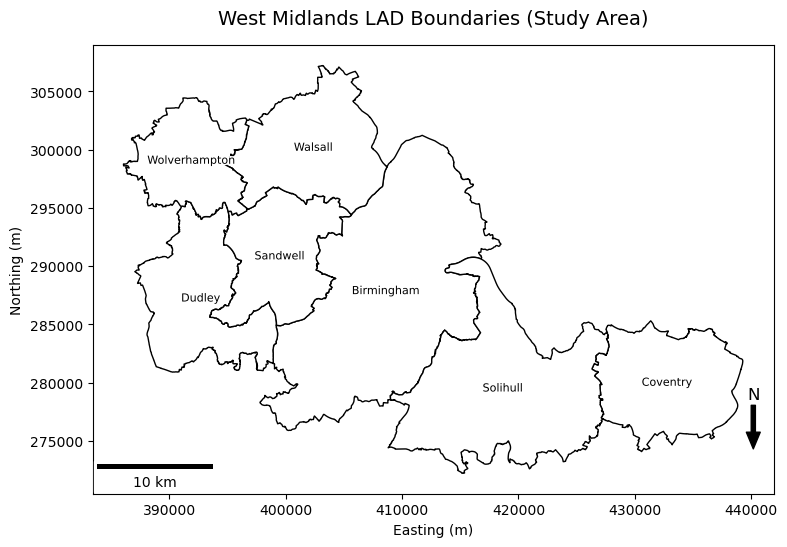

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import io
import json
import matplotlib.patheffects as pe
from matplotlib_scalebar.scalebar import ScaleBar

# -------------------------------
# 1. ArcGIS query limited to West Midlands LAD
# -------------------------------
lad_codes = [
    "E08000025", "E08000026", "E08000027",
    "E08000028", "E08000029", "E08000030", "E08000031"
]
lad_code_query = " or ".join([f"LAD23CD='{code}'" for code in lad_codes])

lad_url = (
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
    "Local_Authority_Districts_December_2023_Boundaries_UK_BFE/FeatureServer/0/"
    f"query?where={lad_code_query}&outFields=*&f=geojson"
)

# -------------------------------
# 2. Download and read GeoJSON
# -------------------------------
print("⬇️ Downloading LAD boundaries...")
response = requests.get(lad_url)
if response.status_code != 200:
    raise RuntimeError(f"Download failed, status code: {response.status_code}")

maybe_json = json.loads(response.text)
if "error" in maybe_json:
    raise RuntimeError(f"ArcGIS returned error: {maybe_json['error']['message']}")

lad_gdf = gpd.read_file(io.StringIO(response.text))

# Project to British National Grid (EPSG:27700)
lad_gdf = lad_gdf.to_crs(epsg=27700)
print(f"✅ Loaded successfully, total {len(lad_gdf)} areas")

# -------------------------------
# 3. Visualization with scale bar, north arrow, labels
# -------------------------------
fig, ax = plt.subplots(figsize=(8, 8))

# Plot LAD boundaries
lad_gdf.plot(
    ax=ax,
    facecolor='white',
    edgecolor='black',
    linewidth=1
)

# Add LAD name labels (centered)
for idx, row in lad_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, row["LAD23NM"],  # LAD name field
        ha='center', va='center', fontsize=8,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

# Add scale bar (1: units match CRS → meters)
scalebar = ScaleBar(
    dx=1, units="m", location="lower left", box_alpha=0.8,
    scale_loc="bottom"
)
ax.add_artist(scalebar)

# Add north arrow
ax.annotate(
    'N', xy=(0.97, 0.1), xytext=(0.97, 0.22),
    arrowprops=dict(facecolor='black', width=3, headwidth=10),
    ha='center', va='center', fontsize=12,
    xycoords=ax.transAxes
)

# Labels & title
ax.set_xlabel("Easting (m)", fontsize=10)
ax.set_ylabel("Northing (m)", fontsize=10)
ax.set_title("West Midlands LAD Boundaries (Study Area)", fontsize=14, pad=15)

# Clean layout
plt.tight_layout()
plt.show()



Fire station location distribution

⬇️ Downloading LAD boundaries...
✅ Loaded successfully, total 7 areas


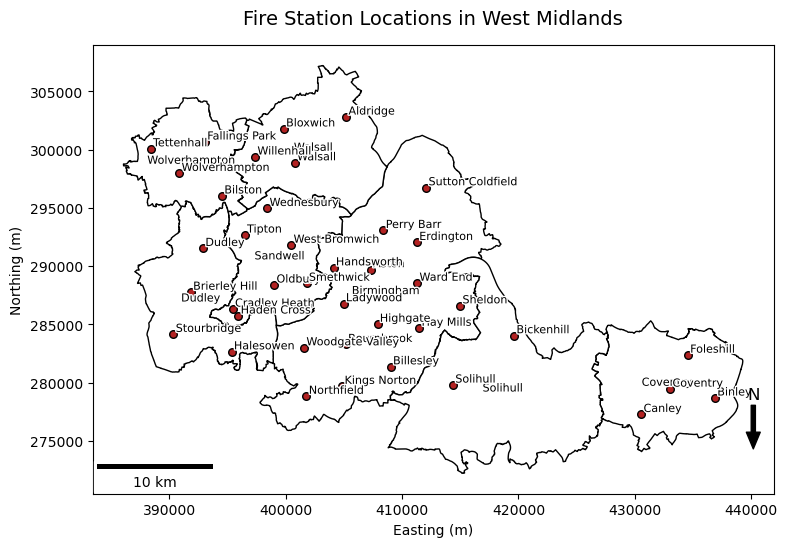

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import io
import requests
import matplotlib.patheffects as pe
import json
from matplotlib_scalebar.scalebar import ScaleBar

# -------------------------------
# 1. Load fire station coordinates
# -------------------------------
station_xy_path = r"D:\UCL2\final论文\station_xy.pkl"
with open(station_xy_path, "rb") as f:
    station_xy = pickle.load(f)

df_station = pd.DataFrame([
    {"station": name, "x": coord[0], "y": coord[1]}
    for name, coord in station_xy.items()
])
gdf_station = gpd.GeoDataFrame(
    df_station,
    geometry=gpd.points_from_xy(df_station["x"], df_station["y"]),
    crs="EPSG:27700"
)

# -------------------------------
# 2. Download LAD boundaries (West Midlands only)
# -------------------------------
lad_codes = [
    "E08000025", "E08000026", "E08000027",
    "E08000028", "E08000029", "E08000030", "E08000031"
]
lad_code_query = " or ".join([f"LAD23CD='{code}'" for code in lad_codes])

lad_url = (
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
    "Local_Authority_Districts_December_2023_Boundaries_UK_BFE/FeatureServer/0/"
    f"query?where={lad_code_query}&outFields=*&f=geojson"
)

print("⬇️ Downloading LAD boundaries...")
response = requests.get(lad_url)
if response.status_code != 200:
    raise RuntimeError(f"Download failed, status code: {response.status_code}")

maybe_json = json.loads(response.text)
if "error" in maybe_json:
    raise RuntimeError(f"ArcGIS returned error: {maybe_json['error']['message']}")

lad_gdf = gpd.read_file(io.StringIO(response.text))
lad_gdf = lad_gdf.to_crs(epsg=27700)
print(f"✅ Loaded successfully, total {len(lad_gdf)} areas")

# -------------------------------
# 3. Visualization with scale bar, north arrow, and labels
# -------------------------------
fig, ax = plt.subplots(figsize=(8, 10))

# Plot LAD boundaries
lad_gdf.plot(
    ax=ax,
    facecolor='white',
    edgecolor='black',
    linewidth=1
)

# Add LAD name labels
for idx, row in lad_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, row["LAD23NM"],
        ha='center', va='center', fontsize=8,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

# Plot fire stations
gdf_station.plot(ax=ax, color="firebrick", markersize=30, edgecolor="black")

# Add station names
for _, row in gdf_station.iterrows():
    ax.text(
        row.x + 200, row.y + 200, row["station"], fontsize=8,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

# Add scale bar (units = meters)
scalebar = ScaleBar(
    dx=1, units="m", location="lower left", box_alpha=0.8, scale_loc="bottom"
)
ax.add_artist(scalebar)

# Add north arrow
ax.annotate(
    'N', xy=(0.97, 0.1), xytext=(0.97, 0.22),
    arrowprops=dict(facecolor='black', width=3, headwidth=10),
    ha='center', va='center', fontsize=12,
    xycoords=ax.transAxes
)

# Labels & title
ax.set_xlabel("Easting (m)", fontsize=10)
ax.set_ylabel("Northing (m)", fontsize=10)
ax.set_title("Fire Station Locations in West Midlands", fontsize=14, pad=15)

# Clean layout
plt.tight_layout()
plt.show()


Number of fire dispatch stations

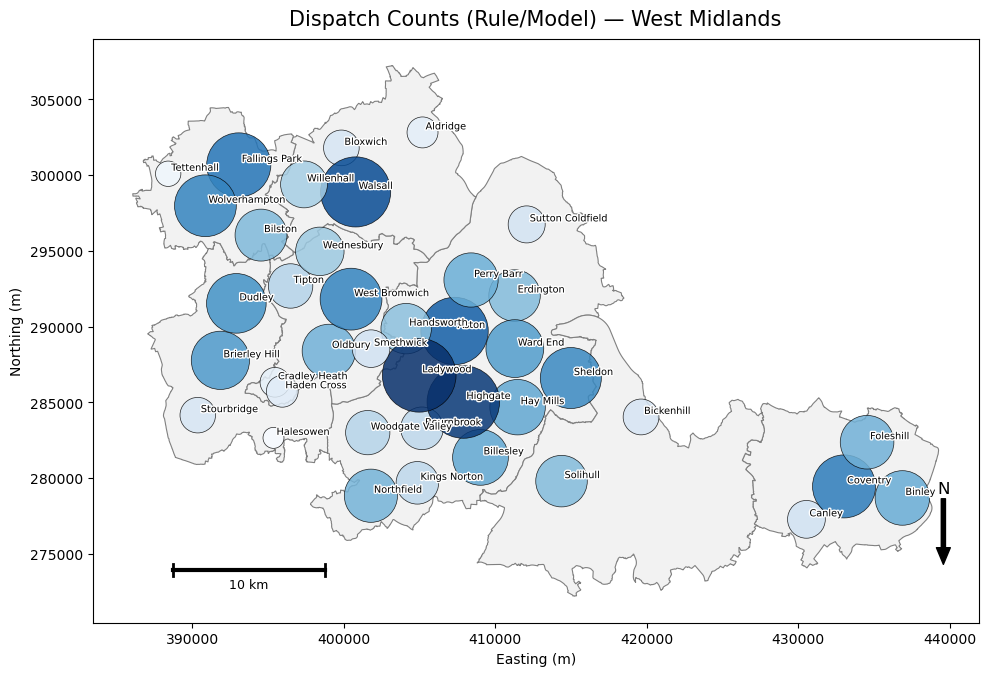

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
import os
import requests
import io
import matplotlib.patheffects as pe

# -------------------------------
# 1) 路径与数据读取
# -------------------------------
base_dir = r"D:\UCL2\final论文"
rule_file  = os.path.join(base_dir, "eval_output", "eval_nearest_dispatch_logrule.csv")
station_xy_file = os.path.join(base_dir, "station_xy.pkl")

with open(station_xy_file, "rb") as f:
    station_xy = pickle.load(f)

df_rule  = pd.read_csv(rule_file)

def count_dispatches(df):
    counts = df.groupby("station").size().reset_index(name="count")
    counts["x"] = counts["station"].map(lambda s: station_xy.get(s, (None, None))[0])
    counts["y"] = counts["station"].map(lambda s: station_xy.get(s, (None, None))[1])
    return counts.dropna(subset=["x", "y"])

dispatch_counts  = count_dispatches(df_rule)

# -------------------------------
# 2) 底图（West Midlands LAD，EPSG:27700）
# -------------------------------
lad_url = (
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
    "Local_Authority_Districts_December_2023_Boundaries_UK_BFE/FeatureServer/0/"
    "query?where=1%3D1&outFields=*&f=geojson"
)
response = requests.get(lad_url)
lad_gdf = gpd.read_file(io.BytesIO(response.content)).to_crs(epsg=27700)

wm_lads = ["E08000025","E08000026","E08000027","E08000028","E08000029","E08000030","E08000031"]
wm_boundary = lad_gdf[lad_gdf["LAD23CD"].isin(wm_lads)]

# -------------------------------
# 3) 绘制地图
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 12))
wm_boundary.plot(ax=ax, color="#f2f2f2", edgecolor="gray", linewidth=0.8)

# 绘制圆点
size_scale = 0.5  # 控制点大小缩放
sc = ax.scatter(
    dispatch_counts["x"], dispatch_counts["y"],
    s=dispatch_counts["count"] * size_scale,
    c=dispatch_counts["count"],
    cmap="Blues",
    edgecolors="black", linewidths=0.5, alpha=0.85,
    marker="o"
)

# 可选：添加站点名称
for _, row in dispatch_counts.iterrows():
    ax.text(row["x"] + 200, row["y"] + 200, row["station"], fontsize=7,
            path_effects=[pe.withStroke(linewidth=2, foreground="white")])

# -------------------------------
# 4) 北箭头 & 比例尺（10 km）
# -------------------------------
# 北箭头
ax.annotate(
    'N', xy=(0.96, 0.10), xytext=(0.96, 0.23),
    arrowprops=dict(facecolor='black', width=3, headwidth=10),
    ha='center', va='center', fontsize=12,
    xycoords=ax.transAxes
)

# 比例尺（10 km）
minx, miny, maxx, maxy = wm_boundary.total_bounds
scalebar_len = 10_000  # 10 km
bar_x = minx + (maxx - minx) * 0.05
bar_y = miny + (maxy - miny) * 0.05
ax.plot([bar_x, bar_x + scalebar_len], [bar_y, bar_y], color='black', linewidth=3)
ax.plot([bar_x, bar_x], [bar_y - 400, bar_y + 400], color='black', linewidth=2)
ax.plot([bar_x + scalebar_len, bar_x + scalebar_len], [bar_y - 400, bar_y + 400], color='black', linewidth=2)
ax.text(bar_x + scalebar_len / 2, bar_y - 1200, "10 km", ha='center', fontsize=9)

# -------------------------------
# 5) 轴、标题
# -------------------------------
ax.set_title("Dispatch Counts (Rule/Model) — West Midlands", fontsize=15, pad=10)
ax.set_xlabel("Easting (m)", fontsize=10)
ax.set_ylabel("Northing (m)", fontsize=10)
ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


In [ ]:
# 🎨 Single plot for Real Dispatch Counts (fixed blue + transparency)
plt.figure(figsize=(9, 10))
wm_boundary.plot(color="#f2f2f2", edgecolor="gray", linewidth=0.8)

sc = plt.scatter(
    rule_counts["x"], rule_counts["y"],
    s=rule_counts["count"] * 0.1,  # Scale down to 0.1 times
    c="#4C72B0",                   # Fixed blue color
    edgecolors="black",
    alpha=0.7                      # Slightly reduced for more visible transparency
)

plt.title("Rule/Model Dispatch Counts", fontsize=12)
plt.xlabel("EASTINGS")
plt.ylabel("NORTHINGS")
plt.gca().set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
import pickle
import os

# 📁 Set paths
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
base_dir = r"D:\UCL2\final论文"
model_file = os.path.join(base_dir, "eval_output", "eval_model_dispatch_logmodel.csv")
station_xy_file = os.path.join(base_dir, "station_xy.pkl")

# 📍 Load fire station coordinates
with open(station_xy_file, "rb") as f:
    station_xy = pickle.load(f)

# 📄 Load dispatch records
df_model = pd.read_csv(model_file)
df_model["x"] = df_model["station"].map(lambda s: station_xy.get(s, (None, None))[0])
df_model["y"] = df_model["station"].map(lambda s: station_xy.get(s, (None, None))[1])
df_model.dropna(subset=["x", "y"], inplace=True)

# 📌 Convert to GeoDataFrame
gdf_model = gpd.GeoDataFrame(df_model, geometry=gpd.points_from_xy(df_model["x"], df_model["y"]), crs="EPSG:27700")

# 📌 Load LAD boundaries
import requests, io
lad_url = (
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
    "Local_Authority_Districts_December_2023_Boundaries_UK_BFE/FeatureServer/0/"
    "query?where=1%3D1&outFields=*&f=geojson"
)
r = requests.get(lad_url)
lad_gdf = gpd.read_file(io.BytesIO(r.content)).to_crs("EPSG:27700")

# 🎯 Keep only West Midlands region
wm_lads = [
    "E08000025", "E08000026", "E08000027", "E08000028",
    "E08000029", "E08000030", "E08000031"
]
wm_boundary = lad_gdf[lad_gdf["LAD23CD"].isin(wm_lads)].copy()

# 📊 Spatial join: assign dispatch points to LAD areas
gdf_joined = gpd.sjoin(gdf_model, wm_boundary, how="inner", predicate="within")

# 📈 Group and count dispatches per LAD area
lad_counts = gdf_joined.groupby("LAD23NM").size().reset_index(name="dispatch_count")
lad_counts = lad_counts.sort_values("dispatch_count", ascending=False)

# ✅ Output top LAD areas by dispatch count
print("📍 Top LAD Areas by Dispatch Count:")
print(lad_counts.head(10))

# 💾 To export as CSV:
# lad_counts.to_csv("lad_dispatch_counts.csv", index=False)


Rule/Model Strategy Dispatch Trajectories

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
import os
import requests
import io

# 📂 Local paths
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
base_dir = r"D:\UCL2\final论文"
model_dir = os.path.join(base_dir, "eval_output")
mobilisations_file = os.path.join(base_dir, "wmfs_mobilisations.csv")
station_xy_file = os.path.join(base_dir, "station_xy.pkl")
model_file = os.path.join(model_dir, "eval_model_dispatch_logmodel.csv")
rule_file = os.path.join(model_dir, "eval_nearest_dispatch_logrule.csv")

# 📄 Load data
df_model = pd.read_csv(model_file)
df_rule = pd.read_csv(rule_file)
df_incidents = pd.read_csv(mobilisations_file)
with open(station_xy_file, "rb") as f:
    station_xy = pickle.load(f)

# 🧬 Function to merge coordinates
def enrich_with_coords(df):
    df["station_x"] = df["station"].map(lambda sid: station_xy.get(sid, (None, None))[0])
    df["station_y"] = df["station"].map(lambda sid: station_xy.get(sid, (None, None))[1])
    incident_coords = df_incidents.set_index("incident_index")[["EASTINGS", "NORTHINGS"]]
    df = df.join(incident_coords, on="incident_index")
    df.rename(columns={"EASTINGS": "incident_x", "NORTHINGS": "incident_y"}, inplace=True)
    df.dropna(subset=["station_x", "station_y", "incident_x", "incident_y"], inplace=True)
    return df

df_model = enrich_with_coords(df_model)
df_rule = enrich_with_coords(df_rule)

# 🔁 Sample same incident_index for trajectory comparison
common_ids = set(df_model["incident_index"]).intersection(df_rule["incident_index"])
sample_ids = pd.Series(list(common_ids)).sample(n=8000, random_state=42)
df_model_sample = df_model[df_model["incident_index"].isin(sample_ids)]
df_rule_sample = df_rule[df_rule["incident_index"].isin(sample_ids)]

# 🗺️ Load West Midlands LAD boundaries
lad_url = (
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
    "Local_Authority_Districts_December_2023_Boundaries_UK_BFE/FeatureServer/0/"
    "query?where=1%3D1&outFields=*&f=geojson"
)
response = requests.get(lad_url)
lad_gdf = gpd.read_file(io.BytesIO(response.content)).to_crs(epsg=27700)
wm_codes = ["E08000025", "E08000026", "E08000027", "E08000028", "E08000029", "E08000030", "E08000031"]
wm_boundary = lad_gdf[lad_gdf["LAD23CD"].isin(wm_codes)]

# 📏 Unify coordinate ranges
x_min = min(df_model_sample[["station_x", "incident_x"]].min().min(),
            df_rule_sample[["station_x", "incident_x"]].min().min())
x_max = max(df_model_sample[["station_x", "incident_x"]].max().max(),
            df_rule_sample[["station_x", "incident_x"]].max().max())
y_min = min(df_model_sample[["station_y", "incident_y"]].min().min(),
            df_rule_sample[["station_y", "incident_y"]].min().min())
y_max = max(df_model_sample[["station_y", "incident_y"]].max().max(),
            df_rule_sample[["station_y", "incident_y"]].max().max())

# 🎯 Consistent visualization style
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

for ax, df, title, color in zip(
    axes,
    [df_rule_sample, df_model_sample],  # 👈 Order for side-by-side comparison
    ["Rule Strategy Dispatch Trajectories", "Model Strategy Dispatch Trajectories"],  # 👈 Titles
    ["#4C72B0", "#55A868"]  # 👈 Colors
):

    wm_boundary.plot(ax=ax, color="#f2f2f2", edgecolor="black", linewidth=0.8)
    for _, row in df.iterrows():
        ax.arrow(row["station_x"], row["station_y"],
                 row["incident_x"] - row["station_x"],
                 row["incident_y"] - row["station_y"],
                 head_width=300, head_length=300,
                 fc=color, ec=color, alpha=0.3, length_includes_head=True)
    ax.set_title(title, fontsize=14)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.axis("equal")
    ax.set_xlabel("EASTINGS")
    ax.set_ylabel("NORTHINGS")

plt.tight_layout()
plt.show()


Dispatch Trajectories (Only Mismatched Cases)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
import io
import os
import requests

# 📁 Path settings
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
base_dir = r"D:\UCL2\final论文"
mobilisation_file = os.path.join(base_dir, "wmfs_mobilisations.csv")
inconsistency_file = os.path.join(base_dir, "调度不一致_站点与时间对比汇总.csv")
station_xy_file = os.path.join(base_dir, "station_xy.pkl")

# 📦 Load data
df_inconsistent = pd.read_csv(inconsistency_file)
df_mobilisations = pd.read_csv(mobilisation_file)

with open(station_xy_file, "rb") as f:
    station_xy = pickle.load(f)

# 🔍 Keep only coordinates for inconsistent events
incident_xy = df_mobilisations[["Incident_Number", "EASTINGS", "NORTHINGS"]]
incident_xy.rename(columns={"Incident_Number": "incident_index"}, inplace=True)
incident_xy = incident_xy.drop_duplicates("incident_index")

# 📊 Parse real and model dispatch station lists
import ast
df_inconsistent["real_stations"] = df_inconsistent["real_stations"].apply(ast.literal_eval)
df_inconsistent["model_stations"] = df_inconsistent["model_stations"].apply(ast.literal_eval)

real_df = df_inconsistent[["incident_index", "real_stations"]].explode("real_stations")
model_df = df_inconsistent[["incident_index", "model_stations"]].explode("model_stations")
real_df["source"] = "Real"
model_df["source"] = "Model"
real_df.rename(columns={"real_stations": "station"}, inplace=True)
model_df.rename(columns={"model_stations": "station"}, inplace=True)

combined_df = pd.concat([real_df, model_df], ignore_index=True)
combined_df = combined_df.dropna(subset=["station"])

# ➕ Add station and incident coordinates
combined_df["station_x"] = combined_df["station"].map(lambda s: station_xy.get(s, (None, None))[0])
combined_df["station_y"] = combined_df["station"].map(lambda s: station_xy.get(s, (None, None))[1])
combined_df = combined_df.merge(incident_xy, on="incident_index", how="left")
combined_df.rename(columns={"EASTINGS": "incident_x", "NORTHINGS": "incident_y"}, inplace=True)
combined_df.dropna(subset=["station_x", "station_y", "incident_x", "incident_y"], inplace=True)

# 🌍 Load West Midlands boundary map
lad_url = (
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
    "Local_Authority_Districts_December_2023_Boundaries_UK_BFE/FeatureServer/0/"
    "query?where=1%3D1&outFields=*&f=geojson"
)
r = requests.get(lad_url)
lad_gdf = gpd.read_file(io.BytesIO(r.content)).to_crs(epsg=27700)
wm_lads = ["E08000025", "E08000026", "E08000027", "E08000028", "E08000029", "E08000030", "E08000031"]
wm_boundary = lad_gdf[lad_gdf["LAD23CD"].isin(wm_lads)]

# 📈 Visualization
fig, ax = plt.subplots(figsize=(10, 12))
wm_boundary.plot(ax=ax, color="#f5f5f5", edgecolor="gray", linewidth=0.6)

# 🔵 Real (blue)
for _, row in combined_df[combined_df["source"] == "Real"].sample(n=5000).iterrows():
    ax.arrow(
        row["station_x"], row["station_y"],
        row["incident_x"] - row["station_x"],
        row["incident_y"] - row["station_y"],
        head_width=200, head_length=300,
        fc="#4C72B0", ec="#4C72B0", alpha=0.25,
        length_includes_head=True
    )

# 🟢 Model/Rule (green)
for _, row in combined_df[combined_df["source"] == "Model"].sample(n=5000).iterrows():
    ax.arrow(
        row["station_x"], row["station_y"],
        row["incident_x"] - row["station_x"],
        row["incident_y"] - row["station_y"],
        head_width=200, head_length=300,
        fc="#55A868", ec="#55A868", alpha=0.25,
        length_includes_head=True
    )

ax.set_title(", fontsize=14)
ax.set_xlabel("EASTINGS")
ax.set_ylabel("NORTHINGS")
ax.axis("equal")
plt.tight_layout()
plt.show()


Model: Response Time Distribution

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Set file paths
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
model_path = r"D:\UCL2\final论文\eval_output\eval_model_dispatch_logmodel.csv"
rule_path = r"D:\UCL2\final论文\eval_output\eval_nearest_dispatch_logrule.csv"

# Read only required columns
usecols = ["incident_index", "station", "response_time"]
df_model = pd.read_csv(model_path, usecols=usecols)
df_rule = pd.read_csv(rule_path, usecols=usecols)

# -------- Response time comparison visualization (separate subplots) --------
bins = range(0, int(max(df_model["response_time"].max(), df_rule["response_time"].max()) + 100), 100)

plt.figure(figsize=(12, 5))

# Subplot 1
plt.subplot(1, 2, 1)
plt.hist(df_model["response_time"], bins=bins, color="#4C72B0", edgecolor="black", alpha=0.7)
plt.title("Rule: Response Time Distribution", fontsize=12) 
plt.xlabel("Response Time (seconds)")
plt.ylabel("Number of Dispatches")
plt.grid(True)

# Subplot 2
plt.subplot(1, 2, 2)
plt.hist(df_rule["response_time"], bins=bins, color="#55A868", edgecolor="black", alpha=0.7)
plt.title("Model: Response Time Distribution", fontsize=12)  
plt.xlabel("Response Time (seconds)")
plt.ylabel("Number of Dispatches")
plt.grid(True)


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set local file path
base_dir = r"D:\UCL2\final论文"# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
model_file = os.path.join(base_dir, "eval_output", "eval_model_dispatch_logmodel.csv")

# Read data
df_model = pd.read_csv(model_file)

# Set style to match matplotlib default white background
plt.style.use("default")
base_color = "#4C72B0"
palette_gradient = sns.light_palette(base_color, n_colors=10, reverse=True)

# ---------- Plot 1: Distribution of Dispatched Vehicles per Event ----------
plt.figure(figsize=(8, 5))
plt.hist(
    df_model['dispatched_vehicle_count'].dropna(),
    bins=range(1, int(df_model['dispatched_vehicle_count'].max()) + 2),
    color=palette_gradient[4],
    edgecolor='black'
)
plt.title('Distribution of Dispatched Vehicles per Event', fontsize=12)
plt.xlabel('Number of Dispatched Vehicles', fontsize=11)
plt.ylabel('Number of Events', fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- Plot 2: Top 10 Stations by Dispatch Count ----------
top_stations = df_model['station'].value_counts().nlargest(10)
colors_top10 = palette_gradient[:10]

plt.figure(figsize=(10, 6))
plt.barh(
    y=top_stations.index,
    width=top_stations.values,
    color=colors_top10,
    edgecolor='black'
)
plt.title('Top 10 Fire Stations by Dispatch Count', fontsize=12)
plt.xlabel('Dispatch Count', fontsize=11)
plt.ylabel('Fire Station', fontsize=11)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# ---------- Plot 3: Average Dispatched Vehicles by Risk Level ----------
risk_levels_order = ["Low Risk", "Medium Risk", "High Risk"]
avg_dispatch = df_model.groupby("risk_level")["dispatched_vehicle_count"].mean().reindex(risk_levels_order)

plt.figure(figsize=(8, 5))
plt.bar(
    x=avg_dispatch.index,
    height=avg_dispatch.values,
    color=palette_gradient[2:5],
    edgecolor='black'
)
plt.title('Average Dispatched Vehicles per Risk Level', fontsize=12)
plt.xlabel('Risk Level', fontsize=11)
plt.ylabel('Average Dispatched Vehicles', fontsize=11)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ---------- Plot 4: Response Time Distribution by Risk Level ----------
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_model,
    x='risk_level',
    y='response_time',
    order=risk_levels_order,
    palette=palette_gradient[2:5]
)
plt.title('Response Time Distribution per Risk Level', fontsize=12)
plt.xlabel('Risk Level', fontsize=11)
plt.ylabel('Response Time (seconds)', fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()


Dispatch Shifts with Multiple Station Closures

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import pickle
import io
import os
from matplotlib.lines import Line2D

# ========== Paths & Data Loading ==========

base_dir = r"D:\UCL2\final论文"# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
model_dir = os.path.join(base_dir, "eval_output")
station_xy_file = os.path.join(base_dir, "station_xy.pkl")
rule_path = os.path.join(model_dir, "eval_nearest_dispatch_logrule.csv")
model_path = os.path.join(model_dir, "eval_model_dispatch_logmodel.csv")

# Stations to be considered as "closed" and shown on the same map
stations_to_test = ["Cradley Heath", "Halesowen", "Sutton Coldfield", "Aston", "Ward End"]

# Output folder
output_folder = os.path.join(base_dir, "shutdown_visuals")
os.makedirs(output_folder, exist_ok=True)

# Load station coordinates
with open(station_xy_file, "rb") as f:
    station_xy = pickle.load(f)

# Load dispatch logs and merge (Rule vs Model)
df_rule = pd.read_csv(rule_path)
df_model = pd.read_csv(model_path)
df_merge = pd.merge(df_rule, df_model, on="incident_index", suffixes=("_rule", "_model"))

# ========== Basemap: West Midlands LAD ==========
lad_url = (
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/"
    "Local_Authority_Districts_December_2023_Boundaries_UK_BFE/FeatureServer/0/"
    "query?where=1%3D1&outFields=*&f=geojson"
)
r = requests.get(lad_url)
lad_gdf = gpd.read_file(io.BytesIO(r.content)).to_crs(epsg=27700)
wm_lads = ["E08000025", "E08000026", "E08000027", "E08000028", "E08000029", "E08000030", "E08000031"]
wm_boundary = lad_gdf[lad_gdf["LAD23CD"].isin(wm_lads)]

# ========== Preprocessing: Count task shifts after closures ==========
# Keep only records where the Rule station is in the closed list AND it changed to a different Model station
affected_all = df_merge[
    df_merge["station_rule"].isin(stations_to_test) &
    (df_merge["station_rule"] != df_merge["station_model"])
]

# Count shifts by (closed station -> receiving station)
transition_counts_all = (
    affected_all
    .groupby(["station_rule", "station_model"])
    .size()
    .reset_index(name="count")
)

# Maximum shift count for each closed station (used for per-station normalization of alpha/linewidth)
max_per_closed = transition_counts_all.groupby("station_rule")["count"].max().to_dict()

# ========== Color mapping: one color per closed station ==========
palette = ["#e45756", "#4c78a8", "#72b7b2", "#f58518", "#54a24b", "#b279a2", "#ff9da6"]
color_map = {st: palette[i % len(palette)] for i, st in enumerate(stations_to_test)}

# ========== Plot: all closed stations' shifts on one map ==========
fig, ax = plt.subplots(figsize=(10, 12))
wm_boundary.plot(ax=ax, color="#f7f7f7", edgecolor="gray", linewidth=0.6)

# Draw shift arrows (different colors for different closed stations)
for _, row in transition_counts_all.iterrows():
    from_station = row["station_rule"]
    to_station = row["station_model"]
    cnt = row["count"]
    if from_station not in station_xy or to_station not in station_xy:
        continue

    x1, y1 = station_xy[from_station]
    x2, y2 = station_xy[to_station]
    c = color_map.get(from_station, "tomato")
    maxc = max_per_closed.get(from_station, cnt)

    ax.arrow(
        x1, y1, x2 - x1, y2 - y1,
        head_width=250, head_length=300,
        alpha=min(0.85, cnt / max(1, maxc)),  # Normalize per closed station
        linewidth=max(1.2, cnt / 50),
        fc=c, ec=c,
        length_includes_head=True
    )

# Plot closed stations (black dots + labels)
for st in stations_to_test:
    if st in station_xy:
        x, y = station_xy[st]
        ax.plot(x, y, "o", color="black", markersize=8)
        ax.text(x + 300, y + 300, st, fontsize=9, color="black")

# Plot receiving stations (small blue dots, no labels to avoid clutter)
replacing_stations = transition_counts_all["station_model"].unique().tolist()
for s in replacing_stations:
    if s in station_xy:
        xx, yy = station_xy[s]
        ax.plot(xx, yy, "o", color="#4c78a8", markersize=4, alpha=0.8)

# Unified appearance
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("EASTINGS")
ax.set_ylabel("NORTHINGS")
ax.set_title("Dispatch Shifts with Multiple Station Closures", fontsize=15)

# Legend: color = closed station; black dot = Closed; blue dot = Replacing
legend_lines = [Line2D([0], [0], color=color_map[st], lw=3, label=st) for st in stations_to_test]
legend_points = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor="black", markersize=8, label="Closed Station"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor="#4c78a8", markersize=6, label="Replacing Station")
]
ax.legend(handles=legend_lines + legend_points, loc="lower left", fontsize=9, ncol=2, frameon=True)

plt.tight_layout()

# Save output
out_path = os.path.join(output_folder, "dispatch_shifts_all_in_one.png")
plt.savefig(out_path, dpi=300)
plt.show()
print(f"✅ Combined map saved: {out_path}")


Reinforcement Learning Model Metrics Analysis

In [1]:
import os
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 📁 Root directory of TensorBoard log files
log_root = "./tensorboard"  # Change to your actual path

# 📌 Function to extract scalars
def extract_scalars_from_event(path):
    ea = EventAccumulator(path)
    ea.Reload()

    tags = [
        "rollout/ep_rew_mean",
        "rollout/ep_len_mean",
        "train/actor_loss",
        "train/critic_loss",
        "train/ent_coef",
        "train/ent_coef_loss",
        "train/learning_rate"
    ]

    data = {}
    for tag in tags:
        if tag in ea.Tags()["scalars"]:
            events = ea.Scalars(tag)
            data[tag] = pd.DataFrame({
                "step": [e.step for e in events],
                tag: [e.value for e in events]
            })

    if not data:
        return None

    df = data.pop(list(data.keys())[0])
    for tag, d in data.items():
        df = pd.merge(df, d, on="step", how="outer")

    return df.sort_values("step").reset_index(drop=True)

# 🔁 Iterate through SAC_1 to SAC_8
for i in range(1, 9):
    run_name = f"SAC_{i}"
    run_path = os.path.join(log_root, run_name)

    if os.path.exists(run_path):
        print(f"📥 Processing: {run_name}")
        df_metrics = extract_scalars_from_event(run_path)
        if df_metrics is not None:
            df_metrics.to_csv(f"{run_name}_metrics.csv", index=False)
            print(f"✅ Successfully saved: {run_name}_metrics.csv")
        else:
            print(f"⚠️ No valid data: {run_name}")
    else:
        print(f"❌ Path does not exist: {run_path}")


📥 Processing: SAC_1
✅ Successfully saved: SAC_1_metrics.csv
📥 Processing: SAC_2
⚠️ No valid data: SAC_2
📥 Processing: SAC_3
✅ Successfully saved: SAC_3_metrics.csv
📥 Processing: SAC_4
✅ Successfully saved: SAC_4_metrics.csv
📥 Processing: SAC_5
✅ Successfully saved: SAC_5_metrics.csv
📥 Processing: SAC_6
✅ Successfully saved: SAC_6_metrics.csv
📥 Processing: SAC_7
✅ Successfully saved: SAC_7_metrics.csv
📥 Processing: SAC_8
✅ Successfully saved: SAC_8_metrics.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 📂 1. Set path and read data
# ⚠️ This is a local file path, please ensure the file exists at this location on your machine
metrics_path = r"D:\UCL2\code\SAC_8_metrics.csv"
df = pd.read_csv(metrics_path)

# 🧹 2. Clean data (if necessary)
df = df.dropna(subset=["step", "rollout/ep_rew_mean"]).copy()
df["step"] = df["step"].astype(int)

# 🎨 3. Plot Reward convergence curve
plt.figure(figsize=(10, 6))
plt.plot(df["step"], df["rollout/ep_rew_mean"], label="Episode Mean Reward", color="royalblue")
plt.xlabel("Training Steps")
plt.ylabel("Mean Episode Reward")
plt.title("📈 SAC_8: Reward Convergence During Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 🧾 4. Output final and best performance
final_reward = df["rollout/ep_rew_mean"].iloc[-1]
best_reward = df["rollout/ep_rew_mean"].min()

print(f"✅ Final reward: {final_reward:,.0f}")
print(f"🌟 Best reward: {best_reward:,.0f}")
